# Meilleure estimation de la qualité : utilisation de jeux d'entraînement et de validation distincts

## Utilisation de tous les pixels

In [1]:
# chemin vers les librairies personnelles
import sys
sys.path.append('libsigma')

# import des librairies classiques
import os
import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters d'entrée
# inputs / fichiers en entrée
my_folder = 'data/td_classif'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

### Exercice 1 : Séparer les échantillons en deux lots : entrainement et validation. 
1. Testez plusieurs fois la fonction train_test_split et vérifiez que la séparation est bien aléatoire ;
2. Rajoutez l'étape de séparation des échantillons dans le script de classification complet que vous avez produit lors de la dernière séance et corrigez le en conséquence ;
3. Lancez la classification :<br>
3.1. Commentez les résultats : sont-ils similaires à ce que vous avez trouvé dans le précédent TD ? <br>
3.2. Re-lancez plusieurs fois la classification pour voir si vous obtenez des résultats différents ?<br>
3.3. Changez la proportion d'échantillons utilisée pour l'entraînement pour voir si cela influence les résultats.


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:2154 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


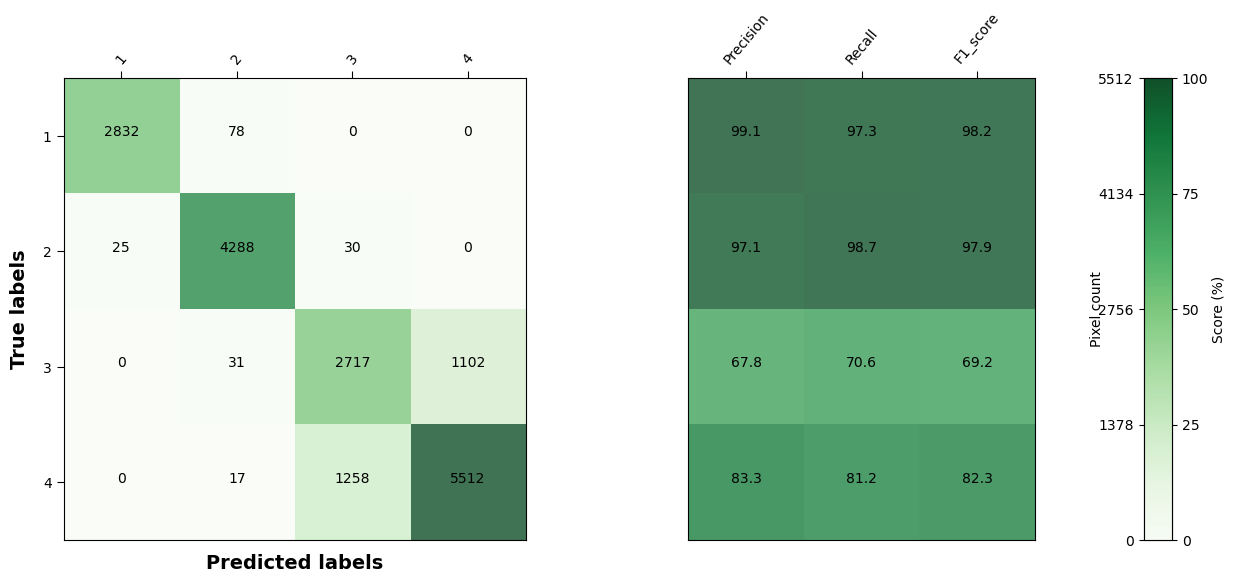

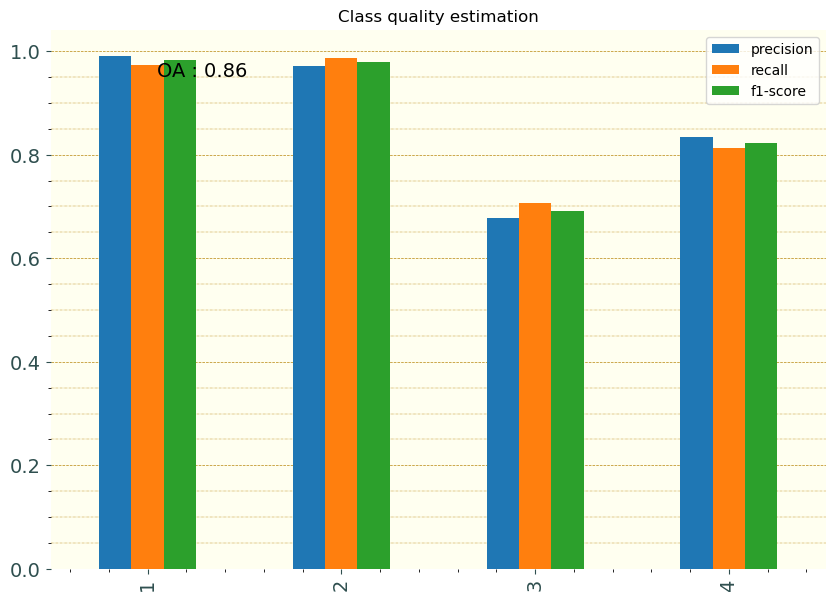

In [3]:
# Sample parameters / paramètres échantillonnage
test_size = 0.7

# outputs / chemin de sortie
suffix = '_v2'
out_classif = os.path.join(my_folder, 'ma_classif1{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice1{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites1{}.png'.format(suffix))

# 2 --- extract samples
# X = features ; Y = labels
X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
# séparation en données d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

# 3 --- Train / entraînement du modèle
# initialisation arbre de décision (page 5 cours)
#clf = SVC(cache_size=6000)
clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
# entraîne sur X et Y (données d'entraînement)
clf.fit(X_train, Y_train)

# 4 --- Test / évaluation du modèle
Y_predict = clf.predict(X_test)

# compute quality
# matrice de confusion : visualiation des performances d'un classifier, compare les prédicitons avec les vraies valeurs
cm = confusion_matrix(Y_test, Y_predict)
# vue d'ensemble complète de la précision, du recall et du F1-score
report = classification_report(Y_test, Y_predict, labels=np.unique(Y_predict), output_dict=True)
# précision globale du modèle (% de prédictions correctes par rapport aux étiquettes réelles)
accuracy = accuracy_score(Y_test, Y_predict)

# display and save quality
# sauvegarde matrice
plots.plot_cm(cm, np.unique(Y_predict), out_filename=out_matrix)
plots.plot_class_quality(report, accuracy, out_filename=out_qualite)

# 5 --- apply on the whole image
# load image / chargement de la ROI complète
X_img, _, t_img = cla.get_samples_from_roi(image_filename, image_filename)

# predict image
# prédiction des classes pour chaque pixel de l'image
Y_img_predict = clf.predict(X_img)

# reshape / reformer en 2D
ds = rw.open_image(image_filename)
nb_row, nb_col, _ = rw.get_image_dimension(ds) # dimensions de l'image

#initialization of the array
img = np.zeros((nb_row, nb_col, 1), dtype='uint8')
# assignation des valeurs prédites
img[t_img[0], t_img[1], 0] = Y_img_predict

# write image / sauvegarder l'image classifiée
ds = rw.open_image(image_filename)
rw.write_image(out_classif, img, data_set=ds, gdal_dtype=None,
            transform=None, projection=None, driver_name=None,
            nb_col=None, nb_ligne=None, nb_band=1)

## Les jeux d'entraînement et de validation sont-ils vraiment indépendants ? Utilisation d'un pixel par polygone
### Extraction des échantillons à partir d'un fichier de points
#### Principe

### Exercice 2 : Obtenir les coordonnées géographique d'un point. 
Écrivez une fonction qui renvoie les coordonnées géographiques d'un fichier de points en utilisant Geopandas.

In [4]:
import geopandas as gpd
# définition de la fonction "get_xy_from_file"
def get_xy_from_file(filename):
    """
    Get x y coordinates from a vector point file

    Parameters
    ----------
    filename : str
        Path of the vector point file

    Returns
    -------
    list_x : np.array
    list_y : np.array
    """
    # lecture du fichier, retourne un gdf
    gdf = gpd.read_file(filename)
    # extraction de la colonne géométrie
    geometry = gdf.loc[:, 'geometry']
    # extraction des coordonnées X et Y
    list_x = geometry.x.values
    list_y = geometry.y.values
    # retourne les tableaux des coordonnées X et Y
    return list_x, list_y

#### Conversion des coordonnées géographiques en coordonnées images

### Exercice 3 : Convertir des coordonnées géographiques en coordonnées "image".
Définissez une fonction xy_to_rowcol() qui retourne la ligne et la colonne d'un pixel à partir des coordonnées géographiques xx et yy d'un pixel. Vous renseignerez en plus comme paramètre d'entrée le chemin de l'image.

Astuce : vous avez accès aux fonctions précédemment développées dans le script read_and_write.py.

In [5]:
import sys
sys.path.append('libsigma')
# permet de lire et manipuler des fichiers d'images
import read_and_write as rw

def xy_to_rowcol(x, y, image_filename):
    """
    Convert geographic coordinates into row/col coordinates

    Paremeters
    ----------
    x : float
      x geographic coordinate
    y : float
        y geographic coordinate
    image_filename : str
        Path of the image.

    Returns
    -------
    row : int
    col : int
    """
    # get image infos
    # ouverture de l'image
    data_set = rw.open_image(image_filename)
    # récupération des coordonnées à l'origine
    origin_x, origin_y = rw.get_origin_coordinates(data_set)
    # récupération de la taille des pixels en X et Y
    psize_x, psize_y = rw.get_pixel_size(data_set)

    # convert x y to row col
    # (x - origin_x) donne la distance entre la coordonnée x et l'origine x, divisée par la taille d'un pixel en X
    col = int((x - origin_x) / psize_x)
    col = int((x - origin_x) / psize_x)
    row = - int((origin_y - y) / psize_y)
    # Retourne les indices de ligne (row) et colonne (col)
    return row, col

### Exercice 4 : Extraire la liste des coordonnées "image" des points d'un fichier vecteur (Facultatif).
Bien que cette fonction vous soit déjà fournie, essayez d'écrire cette fonction et comparez la ensuite avec celle du script read_and_write.py.

In [6]:
def get_row_col_from_file(point_file, image_file):
    """
    Get row/col image coordinates from a vector point file
    and an image file

    Parameters
    ----------
    point_file : str
        Path of the vector point file
    image_file : str
        Path of the raster image file

    Returns
    -------
    list_row : np.array
    list_col : np.array
    """
    list_row = []
    list_col = []
    list_x, list_y = get_xy_from_file(point_file)
    for x, y in zip(list_x, list_y):
        row, col = xy_to_rowcol(x, y, image_file)
        list_row.append(row)
        list_col.append(col)
    return list_row, list_col

### Exercice 5 : Vérifier le format d'une matrice. 
La matrice X de l'exemple ci-dessus est-elle bien formatée ? C'est à dire a-t-elle le bon nombre de lignes et de colonnes ? Vérifiez le formellement en python.

In [7]:
import geopandas as gpd

data_set = rw.open_image(image_filename)
image_filename = 'data/td_classif/aumelas_orthoirc.tif'
fichier_point = 'data/td_classif/sample_strata_centroides.shp'
gdf = gpd.read_file(fichier_point)

print('Shape of X :', X.shape)
print('Number of bandes :', rw.get_image_dimension(data_set)[2])
print('Number of samples : ', gdf.shape[0] )

Shape of X : (25557, 3)
Number of bandes : 3
Number of samples :  524


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


Si la matrice **X** correspond aux **valeurs spectrales** de chaque échantillon (donc aux variables à utiliser pour la classification), la matrice **Y** correspond aux **labels** de chaque échantillon, c'est à dire à quelle **classe** ils appartiennent.

### Exercice 6 : Extraire la matrice des labels des échantillons. 
À vous de me le dire. <br>
Indices :<br>
- on l'obtient à partir du fichier d'échantillons ;<br>
- on cherchera à obtenir les labels des échantillons d'apères un champ particulier de la table attributaire ;<br>
- attention au format en sortie (voir figure ci dessus).


In [8]:
import geopandas as gpd
import numpy as np

fichier_point = ('data/td_classif/sample_strata_centroides.shp')
# loading shape file
gdf = gpd.read_file(fichier_point)

Y = gdf.loc[:, 'num']  # get the column containing the sample labels
Y = Y.values  # convert the series into numpy array_cm

# Could have be done in one line : Y = gdf.loc[:, 'num'].values

# the shape is not the desired shape
# print(Y.shape) #  (it's one dimension array)

# Convert it into two dimensions array
# Y = np.atleast_2d(Y)
# print(Y)
# print(Y.shape)  # still not ok --> we want a "column" array, not a "row" array

# Inverse the dimensions
Y = Y.T
print(Y)
print(Y.shape)  # ok

# Could have be done in one line : Y = np.atleast_2d(Y).T

[1 4 2 3 1 2 3 4 4 3 2 1 1 4 3 2 4 3 1 2 1 3 4 1 3 4 2 4 3 1 3 4 1 2 1 3 4
 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

### Classification à partir des échantillons "point"
### Exercice 7 : Entrainer et valider un model à partir d'échantillons "point".
Écrivez une chaîne de traitements pour en entraîner et valider un modèle de classification avec :
- séparation des échantillons en deux jeux d'entraînement et de validation
- en utilisant le jeu d'échantillons sample_strata_centroides.shp


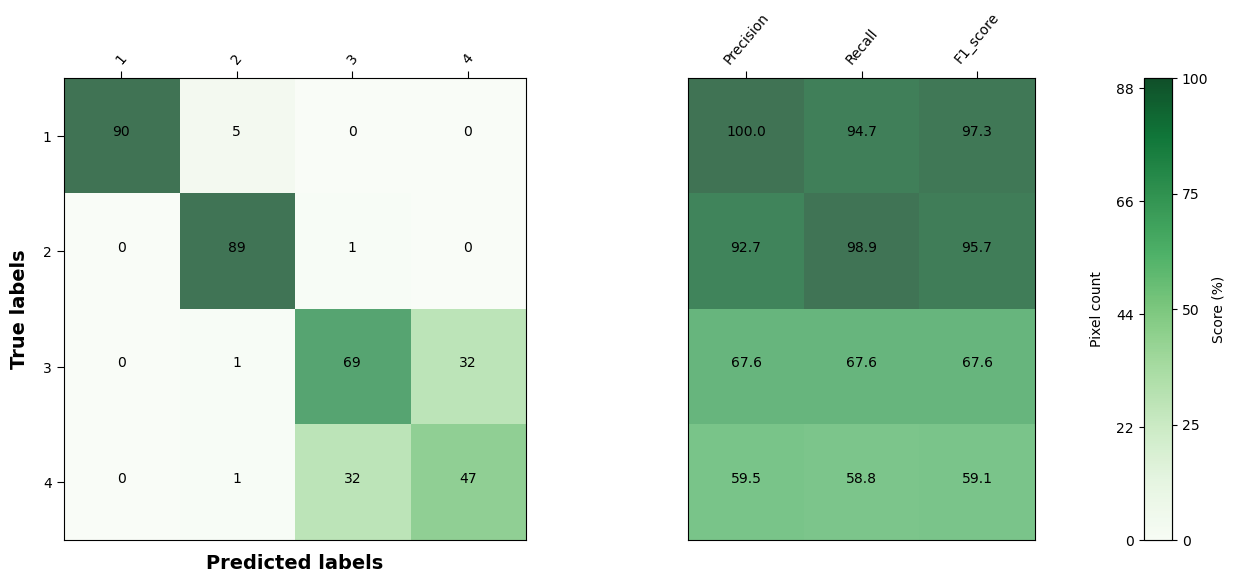

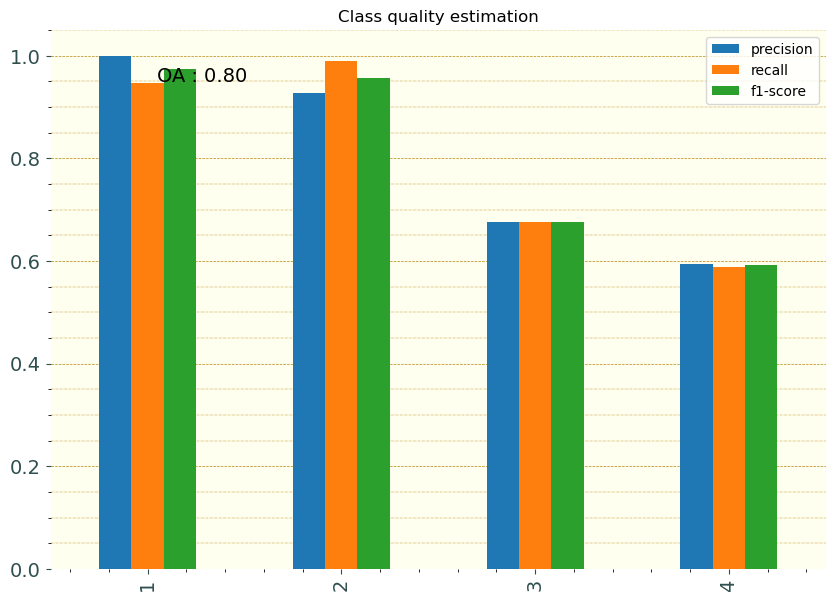

In [9]:
import sys
sys.path.append('libsigma')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters
# inputs
my_folder = 'data/td_classif'
sample_filename = os.path.join(my_folder, 'sample_strata_centroides.shp')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
test_size = 0.7
is_point = True
# if is_point is True
field_name = 'num'

# outputs
suffix = '_v2bis'
out_classif = os.path.join(my_folder, 'ma_classif2{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice2{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites2{}.png'.format(suffix))


# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

    # split sample
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)


# 3 --- Train
#clf = SVC(cache_size=6000)
clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
clf.fit(X_train, Y_train)

# 4 --- Test
Y_predict = clf.predict(X_test)

# compute quality
cm = confusion_matrix(Y_test, Y_predict)
report = classification_report(Y_test, Y_predict, labels=np.unique(Y_predict), output_dict=True)
accuracy = accuracy_score(Y_test, Y_predict)

# display and save quality
plots.plot_cm(cm, np.unique(Y_predict), out_filename=out_matrix)
plots.plot_class_quality(report, accuracy, out_filename=out_qualite)


# Répéter plusieurs fois la validation
## De façon aléatoire
### Exercice 8 : Estimer la qualité d'un modèle sur plusieurs itérations.
Vous disposez d'une fonction report_from_dict_to_df qui permet de convertir en DataFrame un dictionnaire retourné par la fonction classification_report :

In [10]:
import pandas as pd

def report_from_dict_to_df(dict_report):


    # convert report into dataframe
    report_df = pd.DataFrame.from_dict(dict_report)

    # drop unnecessary rows and columns
    try :
        report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
    except KeyError:
        print(dict_report)
        report_df = report_df.drop(['micro avg', 'macro avg', 'weighted avg'], axis=1)

    report_df = report_df.drop(['support'], axis=0)

    return report_df

1. Écrivez une série d'instructions pour répéter nb_iter = 30 fois l'entraînement et la validation d'un modèle de classification ;
2. Stocker :
        les matrices de confusion dans une liste list_cm,
        les accords globaux dans une liste list_accuracy.
        les rapport de classification sous forme de DataFrame dans une liste list_report .

### 1- définir les paramètres des fichiers en entrée et des échantillons

In [11]:
##### 1. Définir les paramètres des fichiers en entrée et des échantillons 
# 1 --- define parameters
# inputs
my_folder = 'data/td_classif'
sample_filename = os.path.join(my_folder, 'sample_strata_centroides.shp')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
test_size = 0.5
is_point = True
# if is_point is True
field_name = 'num'

# outputs
suffix = '_v2'
out_classif = os.path.join(my_folder, 'ma_classif3{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice3{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites3{}.png'.format(suffix))

##### 2. Extraire les échantillons dans une liste et séparer les données test et train
# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

for i in range(30):  
    # Split sample
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

##### 3. Entraîner le modèle
    # 3 --- Train
    #clf = SVC(cache_size=6000)
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, Y_train)

##### 4. Tester le modèle et l'évaluer
    # 4 --- Test
    Y_predict = clf.predict(X_test)

    # compute quality
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict,

                                   labels=np.unique(Y_predict), output_dict=True)
    # store them
    list_report.append(report_from_dict_to_df(report))

### Matrice de confusion

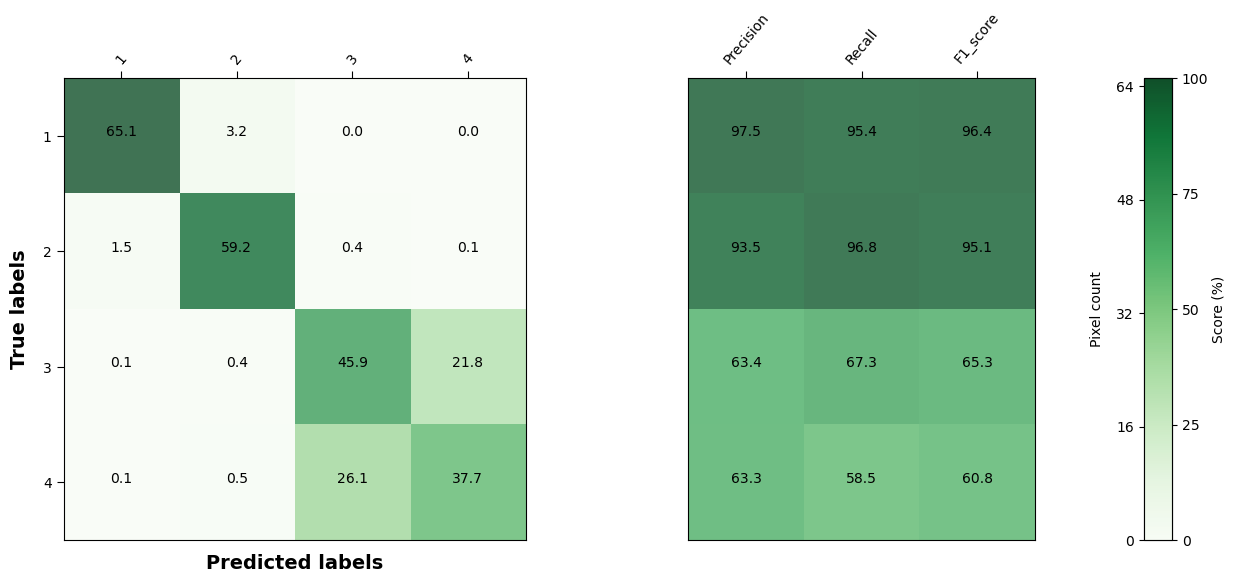

In [12]:
# Calcul
nb_iter = 30
# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# Affichage 
plots.plot_cm(mean_cm, np.unique(Y_predict))

### Calcul de l'Accord global moyen

In [13]:
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

### Moyenne des rapports de classification

In [14]:
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)

### Affichage des qualités
Nous allons reconvertir les tableaux Numpy en DataFrame de Pandas pour afficher plus facilement les résultats 

In [15]:
mean_df_report = pd.DataFrame(mean_report)
mean_df_report

,0,1,2,3
0,0.974369,0.935683,0.638426,0.634773
1,0.954313,0.968617,0.673632,0.587602
2,0.963741,0.951186,0.651789,0.606047


Au passage, vous avez vu comment créer un DataFrame à partir d'un tableau Numpy. Rajoutons maintenant les index à partir des précédents DataFrame.

In [16]:
a_report = list_report[0]
an_index = a_report.index
print(an_index)
a_column_index = a_report.columns
print(a_column_index)
mean_df_report = pd.DataFrame(mean_report, index=an_index,
                              columns=a_column_index)
mean_df_report

Index(['precision', 'recall', 'f1-score'], dtype='object')
Index(['1', '2', '3', '4'], dtype='object')


,1,2,3,4
precision,0.974369,0.935683,0.638426,0.634773
recall,0.954313,0.968617,0.673632,0.587602
f1-score,0.963741,0.951186,0.651789,0.606047


Même chose pour l'écart type :

In [17]:
a_report = list_report[0]
an_index = a_report.index
print(an_index)
a_column_index = a_report.columns
print(a_column_index)
std_df_report = pd.DataFrame(std_report, index=an_index,
                            columns=a_column_index)
std_df_report

Index(['precision', 'recall', 'f1-score'], dtype='object')
Index(['1', '2', '3', '4'], dtype='object')


,1,2,3,4
precision,0.030880,0.028442,0.054645,0.049671
recall,0.021101,0.030245,0.069092,0.082730
f1-score,0.015701,0.015173,0.040115,0.049823


Afficher les résultats :

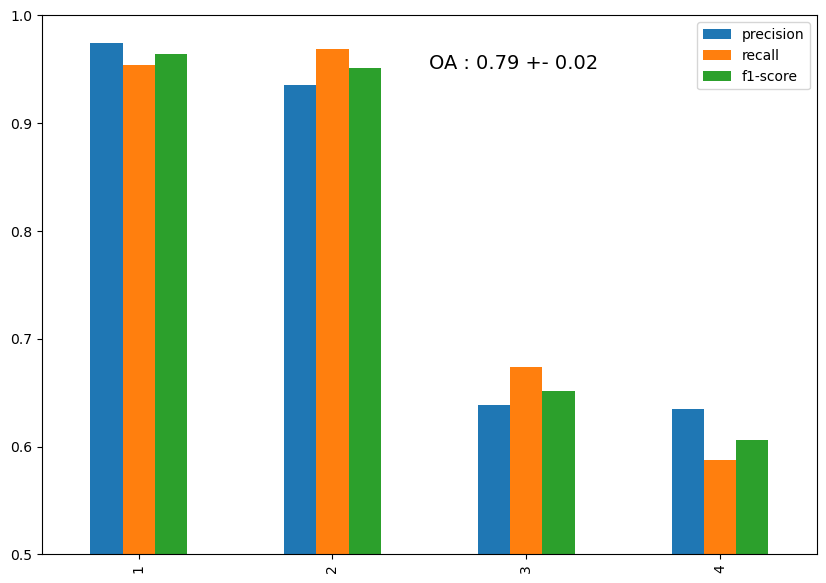

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)

En rajoutant des barres d'erreurs correspondant aux écart-types :

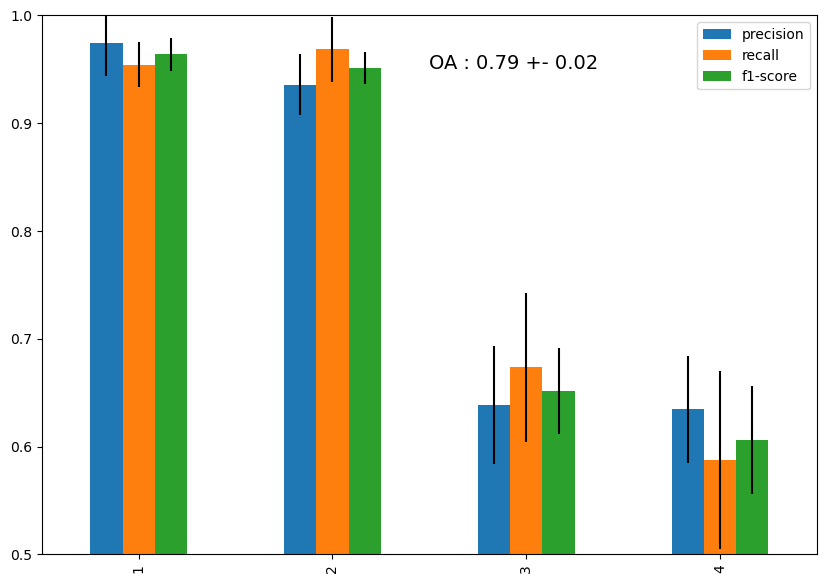

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)

En rajoutant quelques élements graphiques :

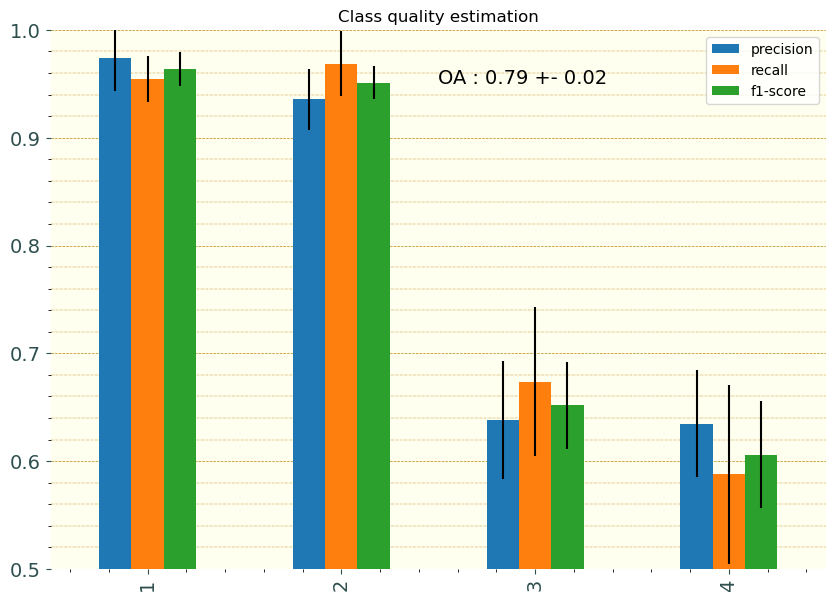

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)

### Exercice 9 : Implémenter une chaine de classification complète avec séparation aléatoire des échantillons, répété plusieurs fois.
Ecrivez une série d'instructions qui permette de répéter plusieurs fois l'entraînement et la validation et d'afficher la synthèse des résultats (compilation des instructions vues ci-dessus).

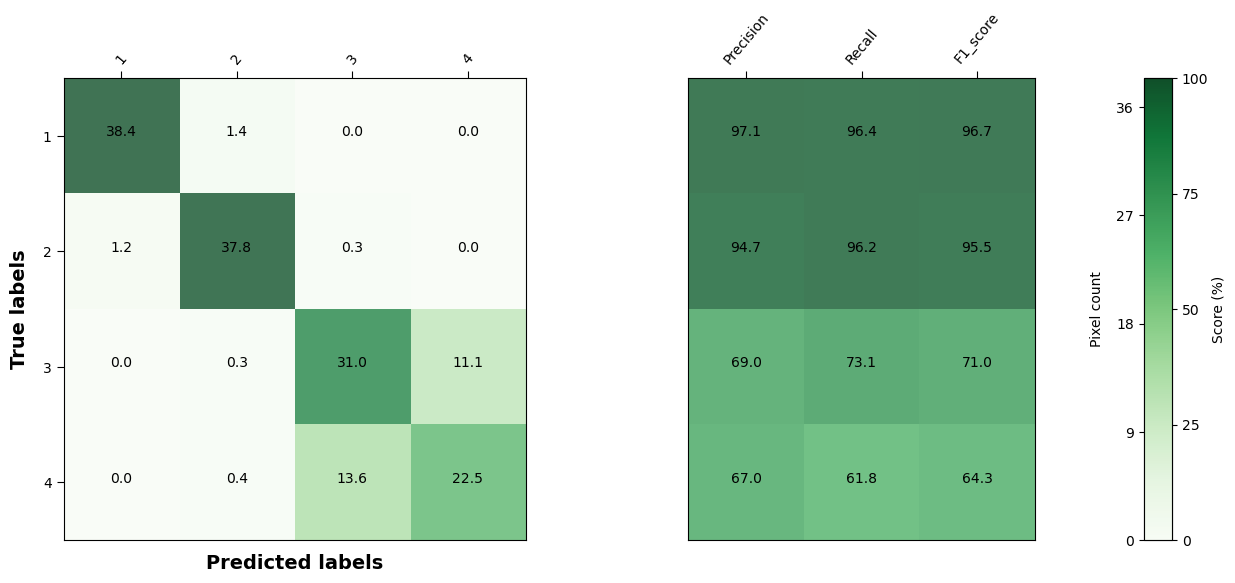

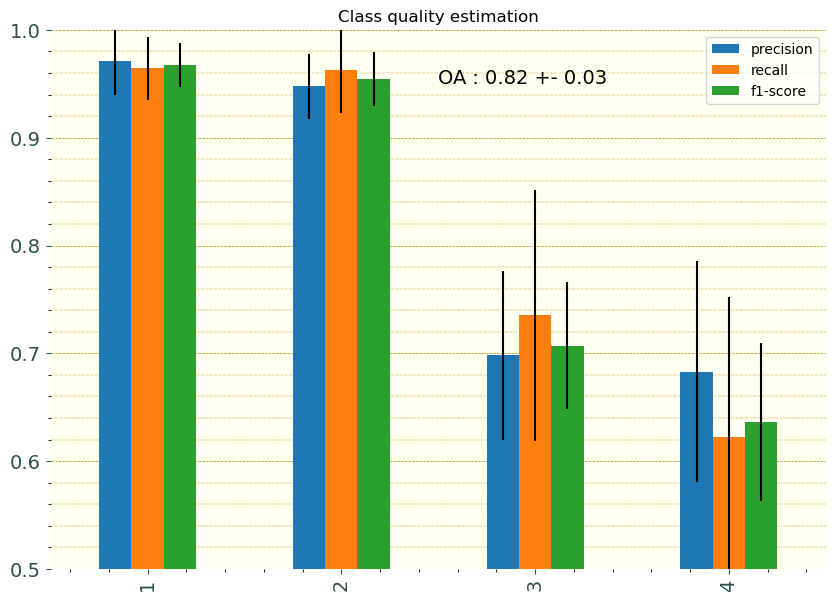

In [21]:
import sys
sys.path.append('libsigma')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# personal librairies
import classification as cla
import read_and_write as rw
import plots 

# 1 --- define parameters
# inputs
my_folder = 'data/td_classif'
sample_filename = os.path.join(my_folder, 'sample_strata_centroides.shp')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
test_size = 0.3
nb_iter = 30
is_point = True
# if is_point is True
field_name = 'num'

# outputs
suffix = '_SplitTest{}Train{}_x{}times'.format(test_size, 1-test_size, nb_iter)
#out_folder = os.path.join(my_folder, 'results')
# j'ai remplac" les "out_folder" par "my_folder" pour les 3 prochaines lignes
out_classif = os.path.join(my_folder, 'ma_classif4{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice4{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites4{}.png'.format(suffix))

# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

for i in range(nb_iter):  
    # Split sample
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)


    # 3 --- Train
    #clf = SVC(cache_size=6000)
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
    clf.fit(X_train, Y_train)

    # 4 --- Test
    Y_predict = clf.predict(X_test)

    # compute quality
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict,

                                   labels=np.unique(Y_predict), output_dict=True)
    # store them
    list_report.append(report_from_dict_to_df(report))


# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')


# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

## De façon croisée et stratifiée
### Principe

C'est cette dernière méthode que nous allons tester, elle est implémenté dans la classe StratifiedKFold du module model_selection, mais nous allons utiliser la classe RepeatedStratifiedKFold qui permet de répéter plusieurs fois la validation croisée stratifiée. Voici un exemple d'utilisation pour 3 folds et 2 répétitions : <br>
On ne sépare pas directement les matrices X et Y en plusieurs folds mais on génère les indices qui permettront d'obtenir de manière itérative les différents folds.

Stratification sans Cross validation : <br>
On évoque seulement maintenant pour la validation croisée la possibilité de séparer les échantillons de manière stratifée mais il également possible de le faire pour une simple séparation aléatoire des échantillons avec la fonction train_test_split. Il suffit de renseigner le paramètre stratify=Y où Y est une matrice de labels de classes selon laquelle stratifier.

### Application

### Exercice 10 : Implémenter une chaine de classification avec validation croisée stratifiée.
- Implémentez cette nouvelle stratégie de validation en stockant comme précédemment les indices de qualité au fur et à mesure qu'ils sont produits ;
- calculez ensuite la synthèse de ces indices et affichez les résultats sous forme de graphique ;
- commentez vos résultats.


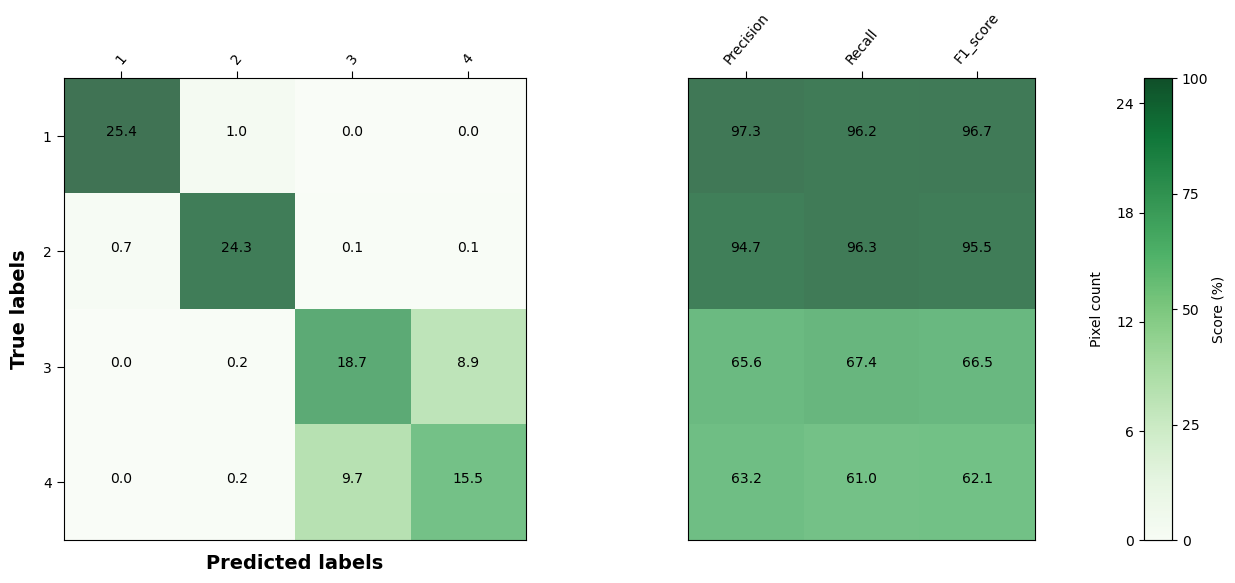

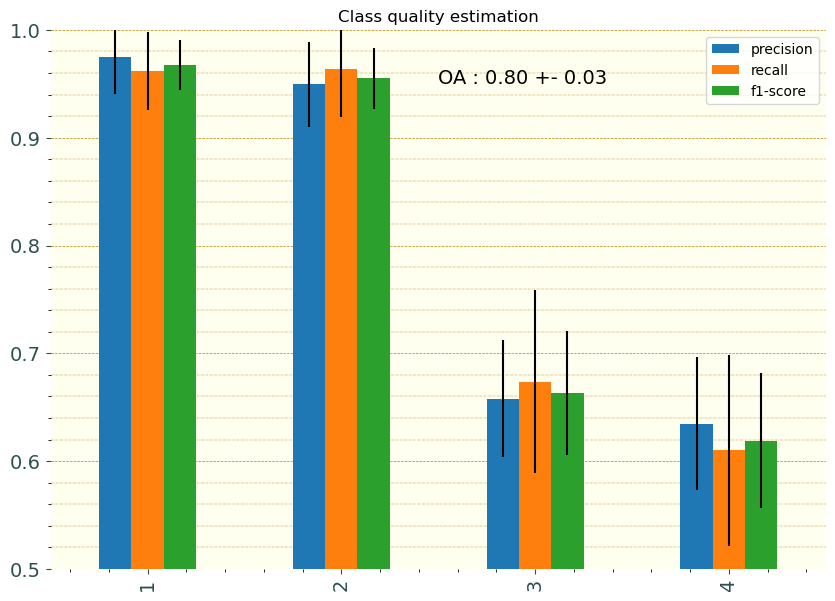

In [22]:
import sys
sys.path.append('libsigma')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters
# inputs
my_folder = 'data/td_classif'
sample_filename = os.path.join(my_folder, 'sample_strata_centroides.shp')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
#test_size = 0.7
nb_iter = 30
nb_folds = 5
is_point = True
# if is_point is True
field_name = 'num'

# outputs
suffix = '_CV{}fold_stratifed_x{}times'.format(nb_folds, nb_iter)
#out_folder = os.path.join(my_folder, 'results')
out_classif = os.path.join(my_folder, 'ma_classif5{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice5{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites5{}.png'.format(suffix))


# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

# Iter on stratified K fold
kf = RepeatedStratifiedKFold(n_splits=nb_folds, n_repeats=nb_iter)
for train, test in kf.split(X, Y):
    X_train, X_test = X[train], X[test]
    Y_train, Y_test = Y[train], Y[test]

    # 3 --- Train
    #clf = SVC(cache_size=6000)
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, Y_train)

    # 4 --- Test
    Y_predict = clf.predict(X_test)

    # compute quality
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict,

                                   labels=np.unique(Y_predict), output_dict=True)

    # store them
    list_report.append(report_from_dict_to_df(report))



# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

## De façon croisée et en prenant en compte les groupes.
### Exercice 11 : Implémenter une chaîne de classification avec validation croisée et en prenant en compte l'appartenance de pixels à un polygone. 
Utiliser la fonction GroupKFold pour implémenter une chaîne de classification avec validation croisée à 5 folds et en prenant en compte l'appartenance de pixels à un polygone. Moyennez les résultats sur 30 itérations.

Cette fois-ci je ne vous donne pas d'exemple de code. Inspirez vous de l'exercice précédent et de la documentation de la classe GroupKFold.

Remarque :
- cette fois ci, il faut bien utiliser tous les pixels à notre disposition et non plus les seuls centroïdes des polygones ;
- Vous pouvez récupérer les identifiants des polygones (les "groupes") à l'aide de la couche sample_srata_id.tif
- Il n'existe pas de classe RepeatedGroupKFold, il faudra gérer les 30 itérations avec une boucle.


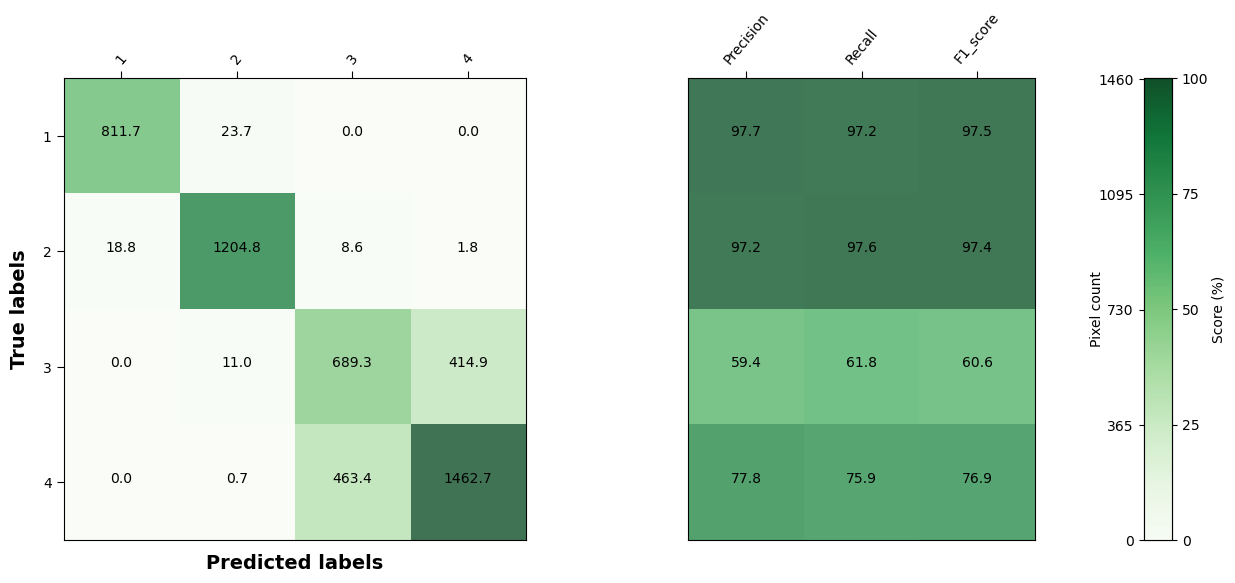

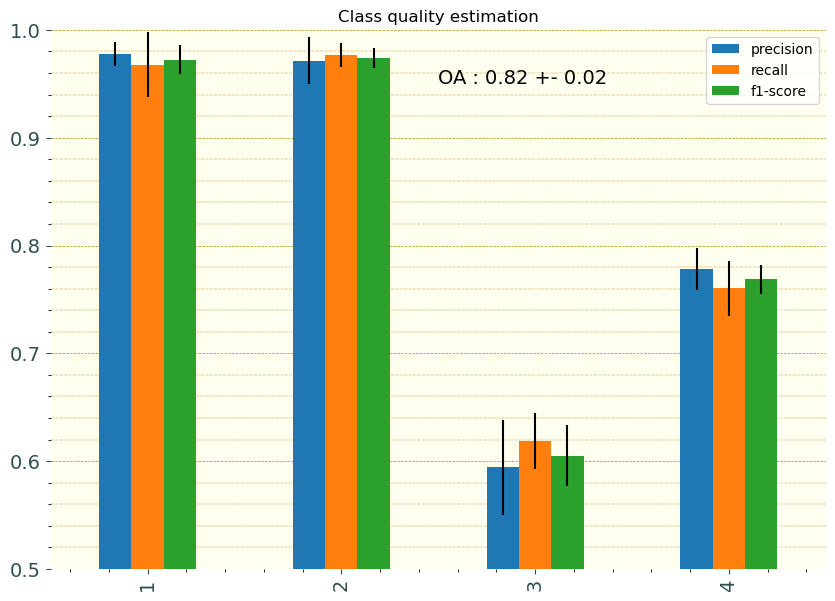

In [23]:
import sys
sys.path.append('libsigma')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters
# inputs
my_folder = 'data/td_classif'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')
id_filename = os.path.join(my_folder, 'sample_strata_id.tif')

# Sample parameters
#test_size = 0.7
nb_iter = 30
nb_folds = 5
is_point = False
# if is_point is True
field_name = 'num'

# outputs
suffix = '_CV{}fold_group_x{}times'.format(nb_folds, nb_iter)
#out_folder = os.path.join(my_folder, 'results')
out_classif = os.path.join(my_folder, 'ma_classif6{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice6{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites6{}.png'.format(suffix))


# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
    _, groups, _ = cla.get_samples_from_roi(image_filename, id_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []
groups = np.squeeze(groups)
# Iter on stratified K fold
for _ in range(nb_iter) :
  kf = GroupKFold(n_splits=nb_folds)
  for train, test in kf.split(X, Y, groups=groups):
      X_train, X_test = X[train], X[test]
      Y_train, Y_test = Y[train], Y[test]

      # 3 --- Train
      #clf = SVC(cache_size=6000)
      clf = tree.DecisionTreeClassifier()
      clf.fit(X_train, Y_train)

      # 4 --- Test
      Y_predict = clf.predict(X_test)

      # compute quality
      list_cm.append(confusion_matrix(Y_test, Y_predict))
      list_accuracy.append(accuracy_score(Y_test, Y_predict))
      report = classification_report(Y_test, Y_predict,
                                     labels=np.unique(Y_predict),
                                     output_dict=True)

      # store them
      list_report.append(report_from_dict_to_df(report))

# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

## De façon croisée, stratifiée et en prenant en compte les groupes
Il est possible de à la fois préserver la distribution des classes dans les jeux d'entraînement et de validation (comme avec la fonction StratifiedKFold) tout en faisant en sorte que les pixels d'un même polygone se trouve dans un seul jeu comme avec la fonction GroupKFold. Utilisez pour cela la fonction StratifiedGroupKFold

### Exercice 12 : Implémenter une chaîne de classification avec validation croisée stratifiée et en prenant en compte l'appartenance de pixels à un polygone.
Utiliser la fonction StratifiedGroupKFold pour implémenter une chaîne de classification avec validation croisée stratifiée et en prenant en compte l'appartenance de pixels à un polygone.

Cette fois-ci je ne vous donne pas d'exemple de code. Inspirez vous de l'exercice précédent et de la documentation de la fonction StratifiedGroupKFold.

Remarque :

- cette fois ci, il faut bien utiliser tous les pixels à notre disposition et non plus les seuls centroïdes des polygones ;
- Vous pouvez récupérer les identifiants des polygones (les "groupes") à l'aide de la couche sample_srata_id.tif

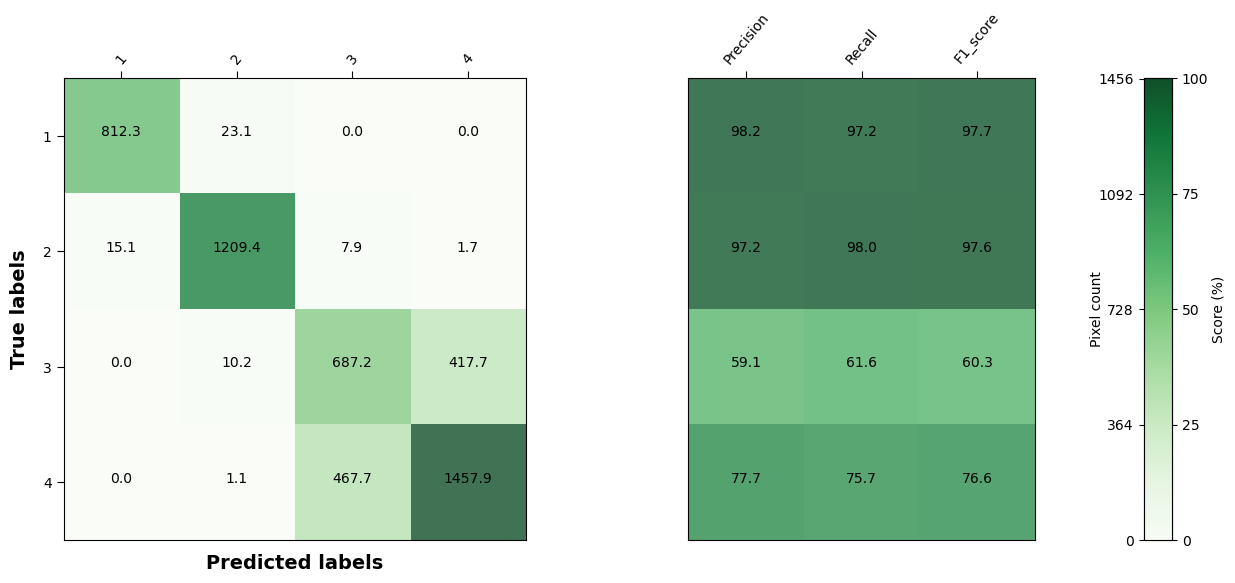

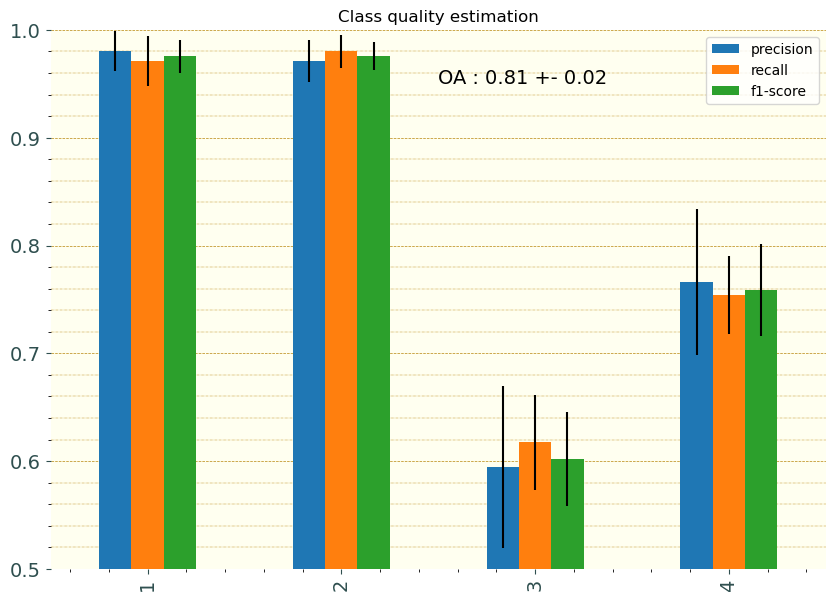

In [24]:
import sys
sys.path.append('libsigma')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters
# inputs
my_folder = 'data/td_classif'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')
id_filename = os.path.join(my_folder, 'sample_strata_id.tif')

# Sample parameters
#test_size = 0.7
nb_iter = 30
nb_folds = 5
is_point = False
# if is_point is True
field_name = 'num'

# outputs
suffix = '_CV{}folds_stratified_group_x{}times'.format(nb_folds, nb_iter)
#out_folder = os.path.join(my_folder, 'results')
out_classif = os.path.join(my_folder, 'ma_classif7{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice7{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites7{}.png'.format(suffix))


# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
    _, groups, _ = cla.get_samples_from_roi(image_filename, id_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []
groups = np.squeeze(groups)

# Iter on stratified K fold
for _ in range(nb_iter):
  kf = StratifiedGroupKFold(n_splits=nb_folds, shuffle=True)
  for train, test in kf.split(X, Y, groups=groups):
      X_train, X_test = X[train], X[test]
      Y_train, Y_test = Y[train], Y[test]

      # 3 --- Train
      #clf = SVC(cache_size=6000)
      clf = tree.DecisionTreeClassifier()
      clf.fit(X_train, Y_train)

      # 4 --- Test
      Y_predict = clf.predict(X_test)

      # compute quality
      list_cm.append(confusion_matrix(Y_test, Y_predict))
      list_accuracy.append(accuracy_score(Y_test, Y_predict))
      report = classification_report(Y_test, Y_predict,
                                     labels=np.unique(Y_predict),
                                     output_dict=True)

      # store them
      list_report.append(report_from_dict_to_df(report))

# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

# Récapitulatif
Voici une petit récapitulatif des différentes stratégies qui ont été abordées.

***Quand séparer le jeu d'entraînement et de validation ?***

Systématiquement, sinon on n'évalue pas la capacité d'un modèle à faire des prédictions correctes sur des échantillons qu'il ne connaît pas.

***Quand faire des répétitions ?***

Systématiquement : la séparation aléatoires des échantillons peut avoir une influence sur la qualité du modèle entrainé. Il faut donc évaluer cet effet. C'est particulièrement important quand le nombre d'échantillons n'est pas très important, tandis que la variabilité des résultats sera a priori moins grande avec un grand nombre d'échantillons.

***Quand faire un validation croisée ?***

Cette méthode est particulièrement recommandé lorsqu'on dispose de peu d'échantillons, mais rien n'empếche de l'utiliser si vous en disposez de beaucoup.

***Quand utiliser une stratégie de stratification ?***

Quand les effectifs de chaque classe sont déséquilibrés.

***Quand tenir compte de l'appartenance des échantillons à un groupe ?***

Quand on suppose que celle-ci peut avoir une influence sur l'estimation de la qualité. Dans notre cas, nous avons utilisé la notion de groupe pour les identifiants des polygones et s'assurer que les pixels d'un même polygone ne puissent pas servir à la fois à l'entraînement et à la validation.

# Optimisation des Hyperparamètres

Dans ces cours, nous n'avons pas abordé les hyperparamètres des modèles utilisés.

Les hyperparamètres sont les paramètres d'un modèle qui sont définis a piori par l'utilisateur. Nous avons par exemple systématiquement défini la valeur l'hyperparamètre ***max_leaf_nodes*** à 10. Le ***DecisionTreeClassifier*** a d'autres hyperparamètres qu'il aurait été possible de changer. D'autres modèles comme les Support Vector Machine (SVM) ou les Random Forest (RF) ont également des hyperparamètres qui leurs sont propres.

Or, ces hyperparamètres peuvent avoir une grande influence sur la qualité des prédictions. Il est donc généralement nécéssaire de chercher les combinaisons d'hyperparamètres qui maximisent la qualité des prédictions.

Vous trouverez plus d'informations sur ces aspects là sur cette page² de scikit-learn et vous les aborderez également dans les cours de machine learning à venir. Ici vous n'avez fait qu'effleurer cette discipline.

² https://scikit-learn.org/stable/modules/grid_search.html#grid-searc

# Regroupement de classes (compromis entre précision thématique et statistique)
Une possibilité pour améliorer votre classification est de regrouper des classes qui ont beaucoup de confusion entre elles a posteriori. Dans notre cas, la classe "Ligneux bas" (classe 3) et "Ligneux hauts" ont beaucoup de confusion (classe 4).

## Évaluation de la qualité
Pour évaluer la qualité d'une classification, vous comparez une matrice de référence Y_test avec une matrice Y_predict contenant les labels prédits par un modèle. Pour évaluer l'effet d'un regroupement de classe sur la qualité d'une classification il suffit de remplacer les valeurs de Y_test et Y_predict par celles souhaitées puis de comparer les deux matrices.

### Exercice 13 : Regrouper des classes --> évaluation de l'effet sur la qualité du résulat ? 
Évaluez l'effet du regroupement de la classe 4 dans la classe 3 (il vous suffit de changer 3-4 lignes de codes dans votre script de classification de la partie précédente).

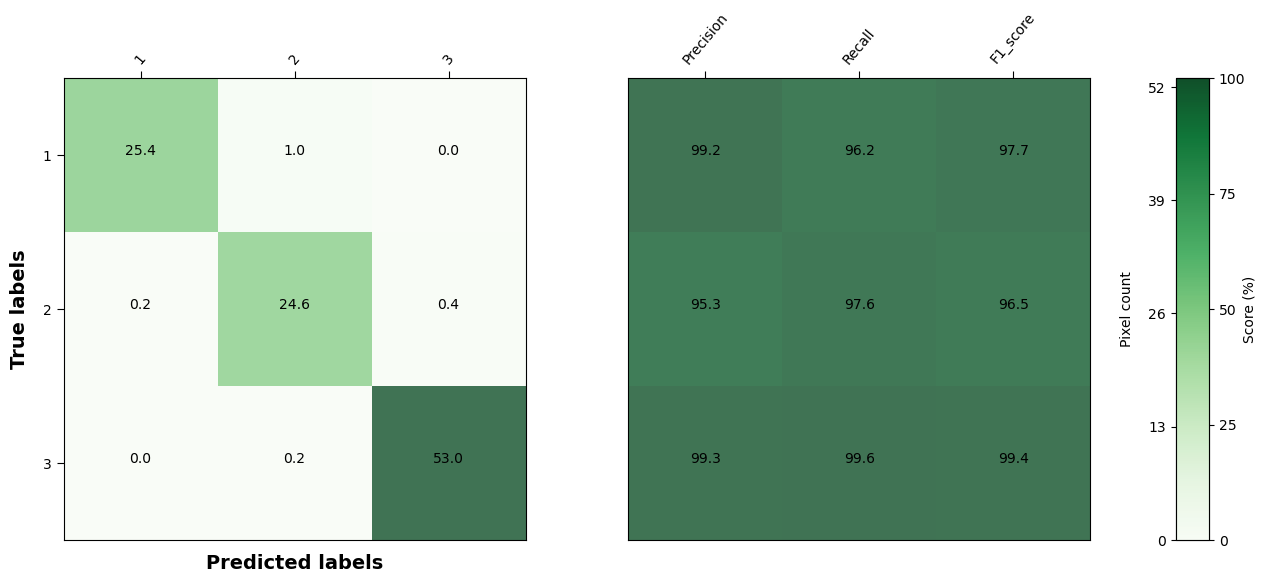

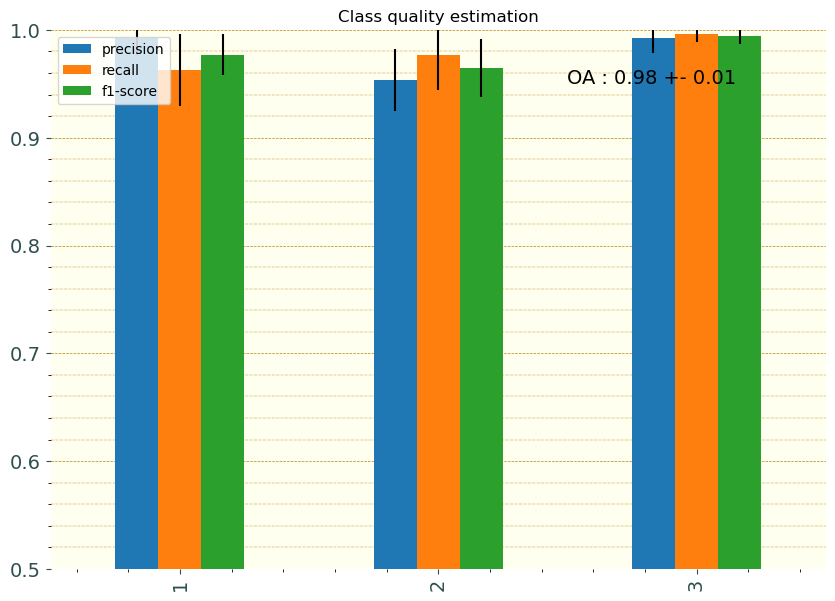

In [25]:
import sys
sys.path.append('libsigma')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters
# inputs
my_folder = 'data/td_classif'
sample_filename = os.path.join(my_folder, 'sample_strata_centroides.shp')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
#test_size = 0.7
nb_iter =5
is_point = True
# if is_point is True
field_name = 'num'

# outputs
suffix = '_v4_regroup'
out_classif = os.path.join(my_folder, 'ma_classif8{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice8{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites8{}.png'.format(suffix))


# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

# Iter on stratified K fold
kf = StratifiedKFold(n_splits=nb_iter)
for train, test in kf.split(X, Y):
    X_train, X_test = X[train], X[test]
    Y_train, Y_test = Y[train], Y[test]

    # 3 --- Train
    #clf = SVC(cache_size=6000)
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, Y_train)

    # 4 --- Test
    Y_predict = clf.predict(X_test)

    Y_predict[Y_predict == 4] = 3
    Y_test[Y_test == 4] = 3
    # compute quality
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict,

                                   labels=np.unique(Y_predict), output_dict=True)

    # store them
    list_report.append(report_from_dict_to_df(report))



# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

## Regroupement de classe d'une image classifiée

### Exercice 14 : Regrouper des classes --> production de la carte.
Maintenant que vous connaissez l'effet du regroupement sur la qualité de votre classification, visualisez le résultat :
1. Chargez l'image ma_premiere_classif_scikit.tif sous forme de tableau ;
2. Effectuez les changements grace à numpy ;
3. Écrivez le résultat dans une image ma_premiere_classif_scikit_regroup.tif

In [26]:
import sys
sys.path.append('libsigma')

import os
import numpy as np
# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters
# inputs
my_folder = 'data/td_classif'
classif_filename = os.path.join(my_folder, 'ma_premiere_classif_scikit.tif')
out_regoup_filename = os.path.join(my_folder, 'ma_premiere_classif_scikit_regroup.tif')

classif = rw.load_img_as_array(classif_filename)
classif[classif==4] = 3
ds = rw.open_image(classif_filename)
rw.write_image(out_regoup_filename, classif, data_set=ds)

Impossible to open data/td_classif/ma_premiere_classif_scikit.tif


AttributeError: 'NoneType' object has no attribute 'RasterXSize'